<a href="https://colab.research.google.com/github/Pongpang-2102/Text_Mining_and_Sentiment_Analytics_KDAI_projects/blob/main/KDAI_Tutorial_TMSA_Text_Summarize_(24_Sep_23).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Sep 24 06:41:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install nltk

In [ ]:
pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184487 sha256=97cdd854dbad895e299ba5a242339c6558344726c3a86b0be2b6e6501ba1cc9c
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a91679966f207bfd71d358d63a8194d
Successfully built python-docx


In [ ]:
pip install transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00


- rouge : เปรียบเทียบการตัดประโยคที่เกิดขึ้นจาก Human และ Machine

In [ ]:
pip install rouge

In [ ]:
pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 97.0 MB/s eta 0:00:00


In [ ]:
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
import pandas as pd

import docx
from docx.enum.text import WD_COLOR_INDEX

import rouge

from transformers import AutoTokenizer, AutoModel

from pythainlp.tokenize import word_tokenize

In [ ]:
# ดึง pre-trained model เอามาใช้ในการสร้าง vector ของประโยค
# Load Wangchanberta Model
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
model = AutoModel.from_pretrained(model_name)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
subword = list(tokenizer.vocab.keys())
df = pd.DataFrame(subword, columns =['subword'])
df.shape

(25004, 1)

In [ ]:
df.head(10)

,subword
0,เลย
1,พอสมควร
2,ยังไม่ทราบ
3,ลาออกจาก
4,ผลึก
5,กอนซา
6,ประกอบ
7,เฟอร์
8,เสาะหา
9,ผู้ชุมนุม


In [ ]:
tokenizer.tokenize('สวัสดีครับชาวโลก')

['▁', 'สวัสดีครับ', 'ชาวโลก']

In [ ]:
inputs = tokenizer('สวัสดีครับชาวโลก', return_tensors='pt')

inputs

{'input_ids': tensor([[    5,    10,  5533, 15873,     6]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [ ]:
inputs['input_ids']

tensor([[    5,    10,  5533, 15873,     6]])

In [ ]:
tokenizer.decode(inputs['input_ids'][0])

'<s> สวัสดีครับชาวโลก</s>'

In [ ]:
outputs = model(**inputs)

outputs[1].shape

torch.Size([1, 768])

- 768 จะเป็นจำนวนเวกเตอร์ ซึ่งจะนำไปคำนวณหา Sentence Similiarity

In [ ]:
outputs[1]

tensor([[-1.7415e-03, -1.8435e-02,  1.6773e-03,  3.2724e-02, -4.5005e-01,
          3.7407e-01,  2.3650e-01, -4.3904e-01,  5.3071e-01,  1.0394e-01,
          2.5839e-01, -2.1191e-01, -4.9980e-02, -4.0315e-01, -4.9616e-01,
          3.0455e-01, -3.9129e-01, -1.5483e-01,  1.1654e-01, -5.8820e-01,
          8.7397e-02, -9.9180e-03,  5.7237e-03,  2.9143e-02,  3.9419e-01,
          2.0283e-01,  3.5851e-01,  2.3526e-01,  2.4379e-01, -8.6311e-02,
          1.2132e-01, -6.0768e-01,  1.0238e-01, -5.0157e-01,  4.9279e-01,
          3.5147e-02,  2.9007e-01, -9.7012e-02, -1.0634e-01,  2.5652e-01,
         -1.8373e-01,  6.6175e-02, -9.7855e-02, -2.6775e-01, -1.5677e-01,
          1.9742e-01,  3.0807e-01, -3.6781e-01, -1.7246e-01,  2.3263e-01,
          2.7887e-01,  1.8814e-01, -1.7076e-01, -9.1214e-03,  9.2614e-02,
         -1.8832e-02, -1.5682e-02,  1.5432e-01,  2.3732e-02, -1.9179e-01,
         -9.1010e-02, -2.3388e-01, -2.0219e-01, -1.9506e-01,  1.0827e-01,
         -9.5903e-02, -4.1159e-02, -3.

In [ ]:
file_name = 'test_project.txt'

with open(file_name, 'r') as file:
    corpus = file.read().splitlines()

print(corpus)

['สัญลักษณ์ทางศิลปะ ไม่ว่าจะเป็นงานเขียนร้อยแก้ว ร้อยกรอง ดนตรี การร่ายรำ ภาพวาด สถาปัตยกรรม คือที่สิ่งบ่งบอกถึงความมีวัฒนธรรมของแต่ละชนชาติที่สืบเนื่องมายาวนาน ', 'ซึ่งร้อยกรองนับเป็นสุนทรียศาสตร์แขนงหนึ่งที่บ่งบอกถึงเรื่องราว และถ่ายทอดอารมณ์ ความรู้สึกนึกคิดของผู้คนในชนชาตินั้นและถูกใช้เป็นสื่อในการเผยแพร่ศิลปะและวัฒนธรรมของชนชาติตน ', 'ดังเช่นที่เราพบว่า ', 'งานประพันธ์ร้อยกรองจีน ร้อยกรองญี่ปุ่น ร้อยกรองอินเดีย ร้อยกรองภาษาอังกฤษ ได้รับความนิยมอย่างแพร่หลายในนานาประเทศ  ', 'และมีงานแปลร้อยกรองจีน ร้อยกรองญี่ปุ่น ร้อยกรองอินเดีย จำนวนมากที่แปลเป็นภาษาอังกฤษ  ', 'และเพื่อเป็นการเผยแพร่บทกวีทั้งต้นฉบับและฉบับแปลในยุคที่เทคโนโลยีสารสนเทศเข้ามามีบทบาท ', 'การเผยแพร่ผ่านสื่อออนไลน์หรือโซเชี่ยลมีเดียจึงเป็นช่องทางที่ได้รับความนิยม ', 'จากตัวอย่างที่มีการจัดตั้งเว็บไซต์ที่รวบรวมงานของเหล่ากวีนานาชาติและแปลเป็นภาษาอังกฤษ ชื่อเว็บไซต์  http://www.poetryintranslation.com/ ซึ่งมีบทกลอนจากหลายชาติ แต่ไม่มีบทกลอนจากกวีไทย ', 'หรือเว็บไซต์ The Poetry Translation Centre’s http://www.poetrytransla

In [ ]:
sentences = [s.strip() for s in corpus]

In [ ]:
sentence_size = len(sentences)
sentence_size

74

In [ ]:
sentences_tokens = [tokenizer(s, return_tensors="pt") for s in sentences]

In [ ]:
sentences_encode = [model(**token) for token in sentences_tokens]

len(sentences_encode)

74

In [ ]:
sentences_encode[0][1].shape

torch.Size([1, 768])

In [ ]:
sentences_vec = [np.squeeze(vec[1].detach().numpy()) for vec in sentences_encode]

sentences_vec[0].shape

(768,)

In [ ]:
def build_similarity_matrix(sentences):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2])

    return similarity_matrix

In [ ]:
def sentence_similarity(sent1, sent2):
    return 1 - cosine_distance(sent1, sent2)

In [ ]:
sentence_similarity_martix = build_similarity_matrix(sentences_vec)

sentence_similarity_martix.shape

(74, 74)

In [ ]:
sentence_similarity_martix

array([[0.        , 0.55170355, 0.29108865, ..., 0.65645695, 0.13526786,
        0.36934159],
       [0.55170355, 0.        , 0.34053639, ..., 0.57727166, 0.11249352,
        0.49919296],
       [0.29108865, 0.34053639, 0.        , ..., 0.27752562, 0.18909414,
        0.41737101],
       ...,
       [0.65645695, 0.57727166, 0.27752562, ..., 0.        , 0.13787499,
        0.45929703],
       [0.13526786, 0.11249352, 0.18909414, ..., 0.13787499, 0.        ,
        0.17237095],
       [0.36934159, 0.49919296, 0.41737101, ..., 0.45929703, 0.17237095,
        0.        ]])

In [ ]:
G = nx.Graph()
G.add_edge('A', 'B', weight=4)
G.add_edge('B', 'D', weight=2)
G.add_edge('A', 'C', weight=3)
G.add_edge('C', 'D', weight=4)

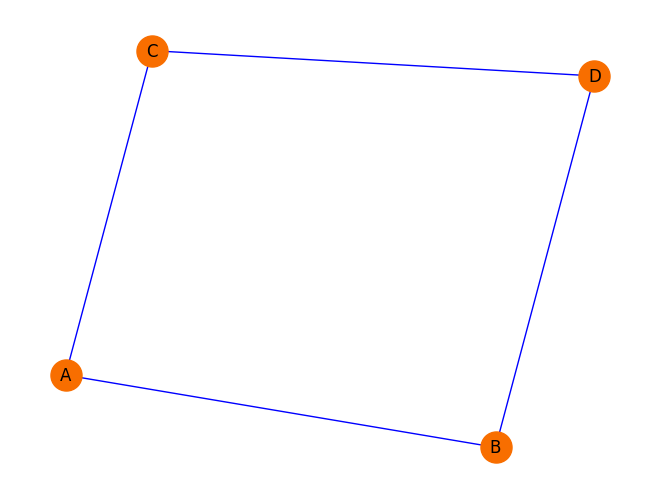

In [ ]:
pos = nx.spring_layout(G, seed=4321)
nx.draw(G,
        pos=pos,
        node_size=500,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True)

In [ ]:
nx.shortest_path(G, 'A', 'D', weight='weight')

['A', 'B', 'D']

In [ ]:
matrixA = np.array([[0., 1., 1.],
                    [0., 0., 0.],
                    [0., 0., 0.]])

g1 = nx.from_numpy_array(matrixA)

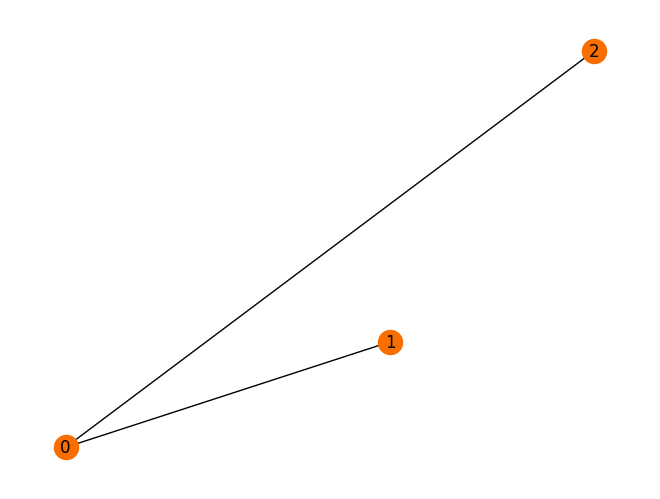

In [ ]:
pos = nx.spiral_layout(g1)

nx.draw(g1,
        pos=pos,
        with_labels = True,
        node_color="#f86e00")

In [ ]:
nx.to_numpy_array(g1)

array([[0., 1., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)

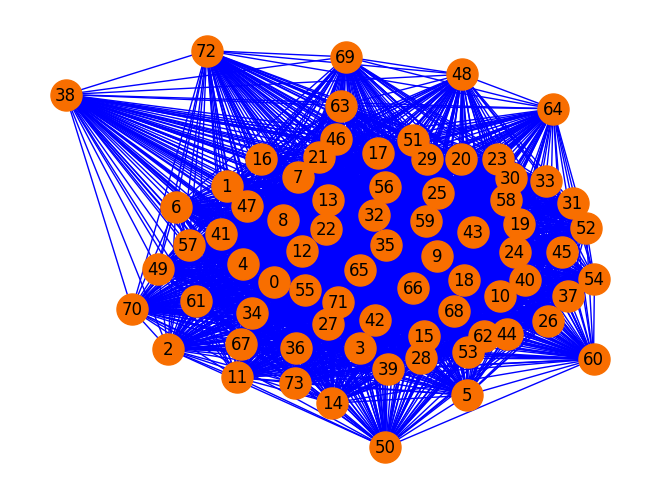

In [ ]:
pos = nx.spring_layout(sentence_similarity_graph, seed=999)

nx.draw(sentence_similarity_graph,
        pos=pos, node_size=500,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True,
        width=1)

- ดึงค่า wt ออกมาดูได้ตามด้านล่าง

In [ ]:
nx.get_edge_attributes(sentence_similarity_graph,'weight')

{(0, 1): 0.5517035484151877,
 (0, 2): 0.29108865335389944,
 (0, 3): 0.6213261633089916,
 (0, 4): 0.6262557238148544,
 (0, 5): 0.2960928418728028,
 (0, 6): 0.46597685239676256,
 (0, 7): 0.618903028638443,
 (0, 8): 0.6053756278208869,
 (0, 9): 0.5917827221084058,
 (0, 10): 0.5354620157527451,
 (0, 11): 0.3423079613649762,
 (0, 12): 0.6048018632725869,
 (0, 13): 0.6820724402755244,
 (0, 14): 0.31573684856526585,
 (0, 15): 0.7205597798614445,
 (0, 16): 0.5976191421691275,
 (0, 17): 0.6046655223816066,
 (0, 18): 0.5869012549830317,
 (0, 19): 0.5884383089483136,
 (0, 20): 0.5417185463189547,
 (0, 21): 0.35576445527277667,
 (0, 22): 0.6208011883144912,
 (0, 23): 0.44869069237248316,
 (0, 24): 0.6589270568268423,
 (0, 25): 0.6256318348849145,
 (0, 26): 0.5802615677728298,
 (0, 27): 0.5894263982527208,
 (0, 28): 0.6210889084218978,
 (0, 29): 0.4947885655545321,
 (0, 30): 0.4749378257434851,
 (0, 31): 0.586459898735723,
 (0, 32): 0.6503193368582982,
 (0, 33): 0.5438410690237773,
 (0, 34): 0.5247

In [ ]:
G = nx.DiGraph()

[G.add_node(k) for k in ['A', 'B', 'C', 'D', 'E', 'F', 'G']]

G.add_edges_from([('G','A'), ('A','G'),('B','A'),
                  ('C','A'),('A','C'),('A','D'),
                  ('E','A'),('F','A'),('D','B'),
                  ('D','F')])

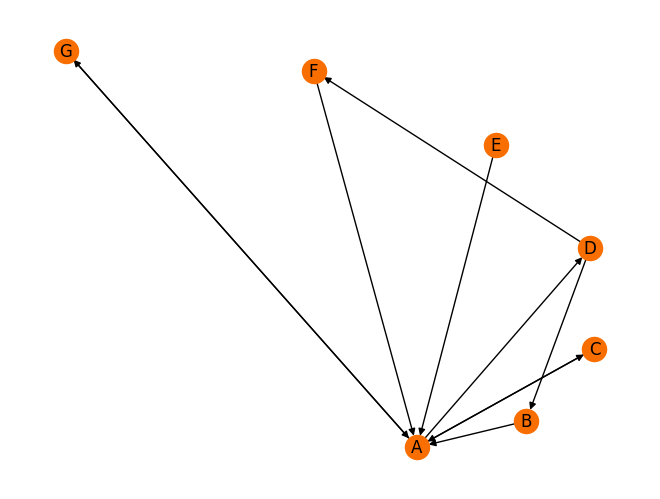

In [ ]:
pos = nx.spiral_layout(G)
nx.draw(G,
        pos=pos,
        with_labels = True,
        node_color="#f86e00")

In [ ]:
pr1 = nx.pagerank(G)

pr1

{'A': 0.4080745143467559,
 'B': 0.07967426232810562,
 'C': 0.13704946318948705,
 'D': 0.13704946318948705,
 'E': 0.021428571428571432,
 'F': 0.07967426232810562,
 'G': 0.13704946318948705}

- ปรับขนาด node ตามค่า PageRank

In [ ]:
PR = [str(round(v * 100, 2)) + '%' for v in pr1.values()]

PR

['40.81%', '7.97%', '13.7%', '13.7%', '2.14%', '7.97%', '13.7%']

In [ ]:
name = [k for k in G._node.keys()]

name

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [ ]:
dict(zip(name, PR))

{'A': '40.81%',
 'B': '7.97%',
 'C': '13.7%',
 'D': '13.7%',
 'E': '2.14%',
 'F': '7.97%',
 'G': '13.7%'}

In [ ]:
size = [v * 6000 for v in pr1.values()]

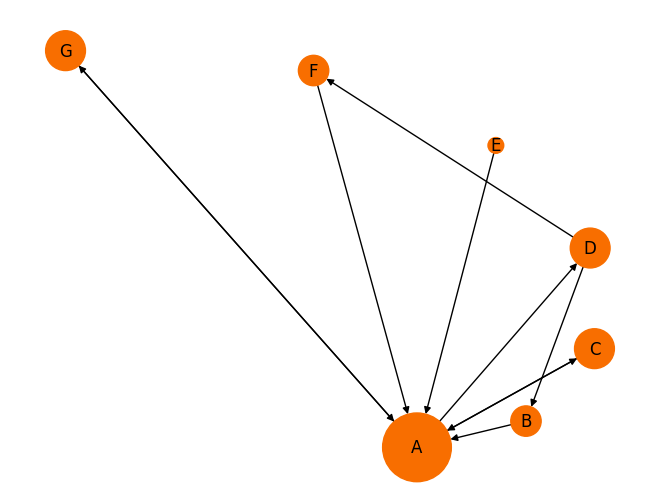

In [ ]:
pos = nx.spiral_layout(G)
nx.draw(G,
        pos=pos,
        with_labels = True,
        node_color="#f86e00",
        node_size=size)

In [ ]:
nx.to_numpy_array(G)

array([[0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
G = nx.DiGraph()
G.add_edge('B', 'A')
G.add_edge('C', 'A')
G.add_edge('D', 'A')
G.add_edge('B', 'C')
G.add_edge('D', 'B')
G.add_edge('D', 'C')

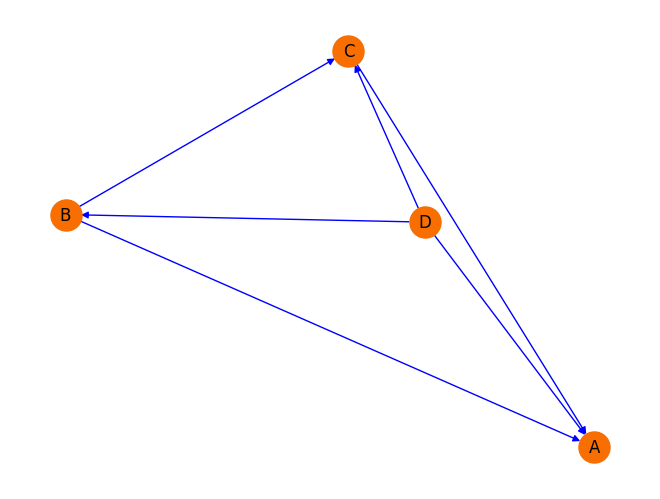

In [ ]:
pos = nx.spring_layout(G, seed=4321)
nx.draw(G,
        pos=pos,
        node_size=500,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True)

In [ ]:
"""PR(A) = 0.25 PR(B) = 0.25 PR(C) = 0.25 PR(D) = 0.25

สำหรับทุก Web Page q ที่ Connect มายัง Web Page A
PR(A) = (1-d) + d*(PR(B)/On(B) + PR(C)/On(C) + PR(D)/On(D))

โดย d หรือ damping factor = 0.85 และ
On(q) เท่ากับจำนวน Link ขาออก (Outgoing Links) ของ Page q

ดังนั้น PR(A) = 0.15 + 0.85(0.25/2 + 0.25/1 + 0.25/3) = 0.5395833333 """

'PR(A) = 0.25 PR(B) = 0.25 PR(C) = 0.25 PR(D) = 0.25\n\nสำหรับทุก Web Page q ที่ Connect มายัง Web Page A\nPR(A) = (1-d) + d*(PR(B)/On(B) + PR(C)/On(C) + PR(D)/On(D))\n\nโดย d หรือ damping factor = 0.85 และ\nOn(q) เท่ากับจำนวน Link ขาออก (Outgoing Links) ของ Page q\n\nดังนั้น PR(A) = 0.15 + 0.85(0.25/2 + 0.25/1 + 0.25/3) = 0.5395833333 '

In [ ]:
PR = nx.pagerank(G)

PR

{'B': 0.17121913703515862,
 'A': 0.4513761585479028,
 'C': 0.24398745873843833,
 'D': 0.13341724567850016}

In [ ]:
nx.to_numpy_array(G)

array([[0., 1., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 0.]])

In [ ]:
nx.to_numpy_array(G)

array([[0., 1., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 0.]])

In [ ]:
D=nx.DiGraph()

D.add_edge('A', 'B')
D.add_edge('A', 'C')

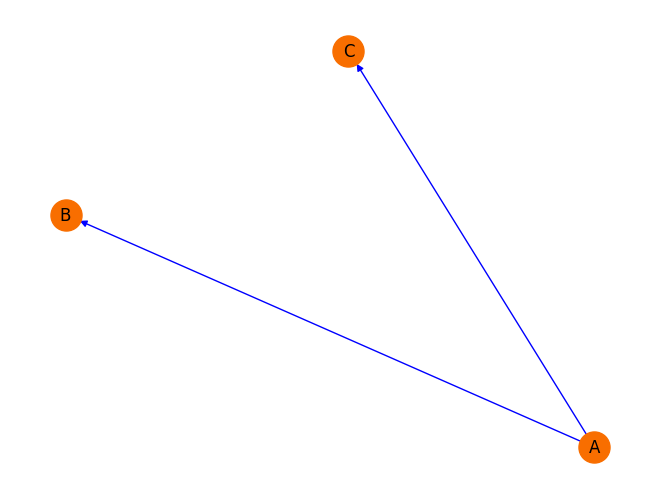

In [ ]:
nx.draw(D,
        pos=pos,
        node_size=500,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True)

In [ ]:
nx.to_numpy_array(D)

array([[0., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
nx.pagerank(D)

{'A': 0.25974050510584634, 'B': 0.37012974744707666, 'C': 0.37012974744707666}

In [ ]:
D.add_weighted_edges_from([('A','B',0.5),('A','C',0.5)])

nx.to_numpy_array(D)

array([[0. , 0.5, 0.5],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ]])

In [ ]:
nx.pagerank(D)

{'A': 0.25974050510584634, 'B': 0.37012974744707666, 'C': 0.37012974744707666}

In [ ]:
D['A']['C']['weight']=1

nx.to_numpy_array(D)

array([[0. , 0.5, 1. ],
       [0. , 0. , 0. ],
       [0. , 0. , 0. ]])

In [ ]:
nx.pagerank(D)

{'A': 0.25974050510584634, 'B': 0.3333333333333332, 'C': 0.40692616156082007}

In [ ]:
pos = nx.spring_layout(sentence_similarity_graph, seed=999)

scores = nx.pagerank(sentence_similarity_graph)

scores

{0: 0.014345838003153562,
 1: 0.01403251719366217,
 2: 0.00985366228542567,
 3: 0.01448202271257487,
 4: 0.015123071984170523,
 5: 0.011320999952322814,
 6: 0.012267462168802446,
 7: 0.016026539782584198,
 8: 0.016216303271004852,
 9: 0.015787258796894202,
 10: 0.015578477097956317,
 11: 0.011214756238463812,
 12: 0.0156602277512887,
 13: 0.015607380108266133,
 14: 0.011218658037647027,
 15: 0.014904059312829123,
 16: 0.014333394008184503,
 17: 0.014863048784356462,
 18: 0.014796798035272538,
 19: 0.015374941597389365,
 20: 0.014403482077949961,
 21: 0.012345501841360221,
 22: 0.015756219800243037,
 23: 0.014225138098993718,
 24: 0.015252721760790271,
 25: 0.015910997636496605,
 26: 0.014810685649435966,
 27: 0.015271580924481918,
 28: 0.015529954793784856,
 29: 0.014361356827414252,
 30: 0.01388687419241186,
 31: 0.015358844476609351,
 32: 0.01594397763390243,
 33: 0.015016840229108847,
 34: 0.014214291702403613,
 35: 0.01608354223822321,
 36: 0.013688845182866009,
 37: 0.015008694255

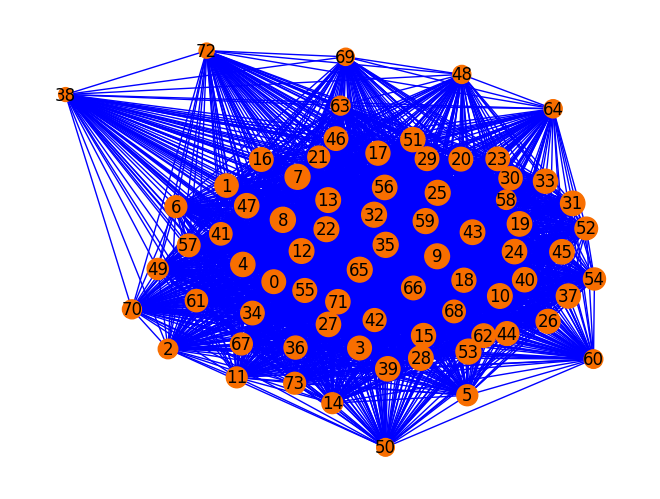

In [ ]:
size = [v * 20000 for v in scores.values()]

nx.draw(sentence_similarity_graph,
        pos=pos,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True,
        width=1,
        node_size=size)

In [ ]:
ranked_sentence = sorted(((scores[i],s) for i, s in enumerate(sentences)), reverse=True)

ranked_sentence

[(0.016216303271004852,
  'หรือเว็บไซต์ The Poetry Translation Centre’s http://www.poetrytranslation.org ซึ่งมีบทกลอนของกวีนานาชาติ และบทกลอนของกวีไทย คือ นายอังคาร จัทราทิพย์ กวีซีไรต์เพียงท่านเดียว'),
 (0.01608354223822321,
  'พบว่าความสำคัญของการแปลกลอนคือการคงลำดับของการสื่อความหมาย อารมณ์ และรูปแบบเสียงสัมผัส ซึ่งเรื่องหลังนี้เป็นเรื่องที่นักแปลมักไม่ให้ความสำคัญเพราะเห็นว่าเป็นเรื่องยากหากจะคงเสียงสัมผัสและความหมายไว้ด้วยกัน'),
 (0.01603880623740886,
  'แต่อย่างไรก็ตามการแปลร้อยกรองไทยให้เป็นภาษาอังกฤษ และคงฉันทลักษณ์ไว้ให้ได้มากที่สุด นับเป็นเรื่องที่ท้าทายสำหรับวงการแปลภาษา และท้าทายสำหรับวงการคอมพิวเตอร์'),
 (0.016026539782584198,
  'จากตัวอย่างที่มีการจัดตั้งเว็บไซต์ที่รวบรวมงานของเหล่ากวีนานาชาติและแปลเป็นภาษาอังกฤษ ชื่อเว็บไซต์  http://www.poetryintranslation.com/ ซึ่งมีบทกลอนจากหลายชาติ แต่ไม่มีบทกลอนจากกวีไทย'),
 (0.015952936641973055,
  'ส่วนงานวิจัยด้านคอมพิวเตอร์และภาษาที่เกี่ยวข้องกับร้อยกรองไทย  ยังมีเพียงแค่การสร้างตัวตรวจทานฉันทลักษณ์คำประพันธ์ ซึ่งมีเพียง 3 วิจัย'

In [ ]:
ranked_sentence[0][0]

0.016216303271004852

In [ ]:
ranked_sentence[0][1]

'หรือเว็บไซต์ The Poetry Translation Centre’s http://www.poetrytranslation.org ซึ่งมีบทกลอนของกวีนานาชาติ และบทกลอนของกวีไทย คือ นายอังคาร จัทราทิพย์ กวีซีไรต์เพียงท่านเดียว'

In [ ]:
top_n = round(sentence_size*0.2)

top_n

15

In [ ]:
sum_text = ''
for i in range(top_n):
  sum_text = sum_text + '\n' + ranked_sentence[i][1]

In [ ]:
sum_list = []
for i in range(top_n):
  sum_list.append(ranked_sentence[i][1])

In [ ]:
original_text = ''
for st in sentences:
  original_text = original_text + '\n' + st

In [ ]:
print('\nSummarize Text: \n', sum_text)


Summarize Text: 
 
หรือเว็บไซต์ The Poetry Translation Centre’s http://www.poetrytranslation.org ซึ่งมีบทกลอนของกวีนานาชาติ และบทกลอนของกวีไทย คือ นายอังคาร จัทราทิพย์ กวีซีไรต์เพียงท่านเดียว
พบว่าความสำคัญของการแปลกลอนคือการคงลำดับของการสื่อความหมาย อารมณ์ และรูปแบบเสียงสัมผัส ซึ่งเรื่องหลังนี้เป็นเรื่องที่นักแปลมักไม่ให้ความสำคัญเพราะเห็นว่าเป็นเรื่องยากหากจะคงเสียงสัมผัสและความหมายไว้ด้วยกัน
แต่อย่างไรก็ตามการแปลร้อยกรองไทยให้เป็นภาษาอังกฤษ และคงฉันทลักษณ์ไว้ให้ได้มากที่สุด นับเป็นเรื่องที่ท้าทายสำหรับวงการแปลภาษา และท้าทายสำหรับวงการคอมพิวเตอร์
จากตัวอย่างที่มีการจัดตั้งเว็บไซต์ที่รวบรวมงานของเหล่ากวีนานาชาติและแปลเป็นภาษาอังกฤษ ชื่อเว็บไซต์  http://www.poetryintranslation.com/ ซึ่งมีบทกลอนจากหลายชาติ แต่ไม่มีบทกลอนจากกวีไทย
ส่วนงานวิจัยด้านคอมพิวเตอร์และภาษาที่เกี่ยวข้องกับร้อยกรองไทย  ยังมีเพียงแค่การสร้างตัวตรวจทานฉันทลักษณ์คำประพันธ์ ซึ่งมีเพียง 3 วิจัย
2) การแปลบทกลอนซึ่งมีสัมผัส มีรูปแบบเสียง จะทำอย่างไรให้คงไว้ได้ในกลอนที่เป็นภาษาปลายทาง
เมื่อแปลเป็นภาษาอังกฤษแล้ว กลับกลายเ

In [ ]:
print('\nOriginal Text: \n', original_text)


Original Text: 
 
สัญลักษณ์ทางศิลปะ ไม่ว่าจะเป็นงานเขียนร้อยแก้ว ร้อยกรอง ดนตรี การร่ายรำ ภาพวาด สถาปัตยกรรม คือที่สิ่งบ่งบอกถึงความมีวัฒนธรรมของแต่ละชนชาติที่สืบเนื่องมายาวนาน
ซึ่งร้อยกรองนับเป็นสุนทรียศาสตร์แขนงหนึ่งที่บ่งบอกถึงเรื่องราว และถ่ายทอดอารมณ์ ความรู้สึกนึกคิดของผู้คนในชนชาตินั้นและถูกใช้เป็นสื่อในการเผยแพร่ศิลปะและวัฒนธรรมของชนชาติตน
ดังเช่นที่เราพบว่า
งานประพันธ์ร้อยกรองจีน ร้อยกรองญี่ปุ่น ร้อยกรองอินเดีย ร้อยกรองภาษาอังกฤษ ได้รับความนิยมอย่างแพร่หลายในนานาประเทศ
และมีงานแปลร้อยกรองจีน ร้อยกรองญี่ปุ่น ร้อยกรองอินเดีย จำนวนมากที่แปลเป็นภาษาอังกฤษ
และเพื่อเป็นการเผยแพร่บทกวีทั้งต้นฉบับและฉบับแปลในยุคที่เทคโนโลยีสารสนเทศเข้ามามีบทบาท
การเผยแพร่ผ่านสื่อออนไลน์หรือโซเชี่ยลมีเดียจึงเป็นช่องทางที่ได้รับความนิยม
จากตัวอย่างที่มีการจัดตั้งเว็บไซต์ที่รวบรวมงานของเหล่ากวีนานาชาติและแปลเป็นภาษาอังกฤษ ชื่อเว็บไซต์  http://www.poetryintranslation.com/ ซึ่งมีบทกลอนจากหลายชาติ แต่ไม่มีบทกลอนจากกวีไทย
หรือเว็บไซต์ The Poetry Translation Centre’s http://www.poetrytranslation.org ซึ่งมีบท

In [ ]:
doc = docx.Document()

doc.add_heading('Summarize Text', 0)

para = doc.add_paragraph('''\n''')

for st in sentences:
  if st.strip() in sum_list:
    para.add_run(st+'\n').font.highlight_color = WD_COLOR_INDEX.YELLOW
  else:
    para.add_run(st+'\n')

doc.save('summarize.docx')